**название проекта:**

<font color='blue'>Определение вероятности оттока клиентов оператора сотовой связи с использованием моделей машинного обучения</font>

**цель проекта:**

Провести анализ имеющихся данных о клиентах и услугах, предоставляемых компанией, сделать выводы о влиянии этих показателей на возможный отказ пользователей от услуг заказчика. Создать модель машинного обучения, которая по средствам классификации достигнет показателя метрики AUC-ROC не ниже 0.85

**План проекта:**
<ol>
<li>Предварительный осмотр имеющихся данных:</li>
<ul>
<li>Импорт необходимых библиотек</li>
<li>Загрузка имеющихся датасетов</li>
<li>Рассмотрение предоставленных данных</li>
<li>Первичный анализ имеющихся данных</li>
</ul>
<li>Предообработка и исследовательский анализ данных:</li>
<ul>
<li>Рассмотрение данных во всех загруженных датасетах, по необходимости преобразование типов данных</li>
<li>Выявление целевого признака</li>
<li>Визуализация и анализ распределения численных данных</li>
<li>По необходимости формирование новых характеристик, которые в дальнейшем помогут в достижении цели проекта</li>
<li>Объединение данных в общий датасет</li>
<li>Определение степени корреляции внутри признаков</li>
<li>Анализ и выявление степени влияния имеющихся данных на целевой признак</li>
<li>Отбор признаков и его обоснование</li>
</ul>
<li>Подготовка данных к обучению модели машинного обучения:</li>
<ul>
<li>Разделение выборки на тренировочную и тестовую части</li>
<li>Выполнение кодирования категориальных данных</li>
</ul>
<li>Выбор модели МЛ:</li>
<ul>
<li>Валидация</li>
<li>Анализ получившихся метрик качества</li>
<li>Выбор лучшей модели для тестирования</li>
</ul>
<li>Тестирование:</li>
<ul>
<li>Тестирование выбранной модели</li>
<li>Анализ полученных метрик качества</li>
</ul>
<li>Отчет о работе над проектом:</li>
<ul>
<li>Описание всех ключевых шагов по выполнению данного проекта</li>
<li>Описание выбранной модели МЛ</li>
<li>Описание полученных метрик</li>
<li>Составление вывода о достижении конечной цели проекта</li>
</ul>
</ol>

In [82]:
!pip install -q phik

In [ ]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer, roc_auc_score
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from lightgbm import LGBMClassifier

warnings.simplefilter(action='ignore')

In [ ]:
random_state = 50623
test_size = 0.25

In [ ]:
!pip install -U -q scikit-learn
!pip install -U -q matplotlib
!pip install -U -q seaborn

Я буду поочередно загружать имеющиеся датасеты и делать краткие выводы по каждому из них.

In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [ ]:
contract.duplicated().sum()

0

In [ ]:
contract.sample(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
452,8847-GEOOQ,2015-02-01,2016-10-01,Month-to-month,Yes,Bank transfer (automatic),60.20,1264.2
3038,5897-ZYEKH,2014-07-01,No,One year,Yes,Electronic check,105.60,7075.2
4022,5863-OOKCL,2019-04-01,No,Month-to-month,No,Mailed check,18.85,188.5


**Датасет Договор:**
Мы имеем датасет, состоящий из 7043 строк и 8 столбцов данных, пропуски и дубликаты в данных отсутствуют. Тип всех колонок строковый, кроме одного столбца, представленного числом с плавающей точкой. Все данные сгруппированны по идентификационному номеру клиента компании. Это: даты начала и конца пользования услугами компании(где данные в последнем столбце отсутствуют-клиент пользуется данными на период загрузки датасета - 01.02.2020), тип оплаты договора, способ оплаты, ежемесячные траты на услуги, итоговые траты на услуги компании.

Пока некоторые интересующие нас признаки не приведены к нужному типу данных, нормально визуализировать мы можем только единственный численный признак - Ежемесячные траты на услуги компании. На распределение остальных признаков пока можем посмотреть весьма поверхностно.

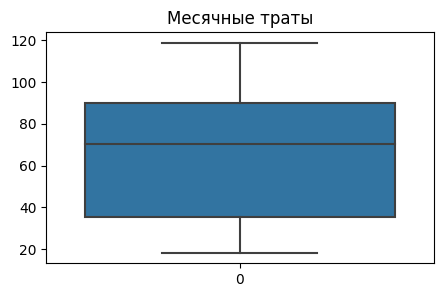

In [ ]:
plt.figure(figsize=(5, 3))
sns.boxplot(data=contract.MonthlyCharges).set_title('Месячные траты');

Мы видим, что в среднем ежемесячные траты составляют около 70, основная масса содержится в интервале от 38 ло 97. Распределение признака с ассиметрией в левую(меньшую) сторону.

In [ ]:
contract.BeginDate.value_counts().to_frame()

,count
BeginDate,
2014-02-01,366
2019-10-01,237
2019-11-01,237
2019-09-01,237
2020-01-01,233
...,...
2020-02-01,11
2014-01-01,7
2013-10-01,3


In [ ]:
contract.EndDate.value_counts().to_frame()

,count
EndDate,
No,5942
2020-01-01,39
2019-12-01,38
2018-11-01,35
2019-09-01,32
...,...
2014-09-01,2
2014-12-01,2
2014-06-01,1


Значимо большее количество (5942) клиентов компании не имеют срока окончания обслуживания, значит продолжают пользоваться услугами компании.

In [ ]:
contract.Type.unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [ ]:
contract.PaymentMethod.unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

Мы видим, что столбцы Тип оплаты и Метод оплаты имеют по 3 и 4 уникальных значения соотвественно, а столбец Безналичный расчет представлен как бинарный идентификатор.

In [ ]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
personal.duplicated().sum()

0

In [ ]:
personal.sample(3)

,customerID,gender,SeniorCitizen,Partner,Dependents
2220,2234-EOFPT,Male,0,Yes,No
2881,4003-OCTMP,Female,0,Yes,No
5301,2082-OJVTK,Male,0,Yes,Yes


**Датасет Личные данные:**
Включает в себя 7043 строки и 5 столбцов с данными, пропуски и дубликаты отсутствуют. Тип данных строковый, кроме столбца Пенсионный статус - целое число. Данные также сгруппированны по идентификационному номеру клиента. Все данные кроме ID предствалены в виде бинарных идентификаторов.

In [ ]:
personal[['gender', 'SeniorCitizen', 'Partner', 'Dependents']].value_counts().to_frame(name='Итого:')

Итого:
gender SeniorCitizen Partner Dependents        
Male   0             No      No            1381
Female 0             No      No            1338
                     Yes     Yes            844
Male   0             Yes     Yes            822
Female 0             Yes     No             596
Male   0             Yes     No             567
Female 1             No      No             317
Male   1             Yes     No             281
                     No      No             244
       0             No      Yes            211
Female 1             Yes     No             209
       0             No      Yes            142
Male   1             Yes     Yes             44
Female 1             Yes     Yes             39
Male   1             No      Yes              5
Female 1             No      Yes              3

В представленной таблице мы видим распределение признаков из датасета с личными данными, например больше всего услугами компании пользуются молодые одинокие мужчины без иждивенцев, более основательные выводы в том числе и по этим данным будут сделаны в исследовательском анализу данных.

In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [ ]:
internet.duplicated().sum()

0

In [ ]:
internet.sample(3)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
926,0135-NMXAP,Fiber optic,No,Yes,No,No,Yes,No
1491,9281-PKKZE,DSL,No,No,No,No,Yes,Yes
5310,1113-IUJYX,Fiber optic,Yes,Yes,No,Yes,Yes,Yes


In [ ]:
internet.InternetService.unique()	

array(['DSL', 'Fiber optic'], dtype=object)

**Датасет Интернет:**
Включает 5517 строк и 8 столбцов с данными, пропуски и дубликаты в датасете отсутствуют. Тип данный - строковый. Все данные сгруппированы по идентификационному номеру клиента компании. Каждый столбец с данными представлен только двумя категориями.

In [ ]:
internet[['InternetService', 'OnlineSecurity', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies']].value_counts().to_frame(name='Итого:')

Итого:
InternetService OnlineSecurity DeviceProtection TechSupport StreamingTV StreamingMovies        
Fiber optic     No             No               No          No          No                  511
DSL             No             No               No          No          No                  391
Fiber optic     No             Yes              No          Yes         Yes                 313
                               No               No          Yes         Yes                 284
DSL             Yes            Yes              Yes         Yes         Yes                 222
...                                                                                         ...
Fiber optic     Yes            Yes              No          No          Yes                  24
DSL             Yes            Yes              No          Yes         No                   22
Fiber optic     Yes            Yes              Yes         Yes         No                   18
                               No               Yes         Yes         No                   17
                                                            No          Yes                  17

[64 rows x 1 columns]

Благодаря вышепредставленной таблице мы можем сделать вывод о приоритетах клиентов в использовании интернета, например основной пользователь имеет Интернет сервис - Fiber optic, без подключения каких-либо дополнительных опций. Более подробный анализ будет проведен в исследовательском анализе данных.

In [ ]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [ ]:
phone.duplicated().sum()

0

In [ ]:
phone.sample(3)

,customerID,MultipleLines
4434,4973-RLZVI,No
2390,9297-EONCV,Yes
5923,5012-YSPJJ,No


In [ ]:
phone.MultipleLines.value_counts().to_frame()

,count
MultipleLines,
No,3390
Yes,2971


**Датасет Телефон:**
Включает в себя 6361 строку и 2 столбца с данными, пропуски и дубликаты в данных отсутствуют. Тип данных строковый. Данные сгруппированы по идентификационному номеру клиента. Второй столбец, говорящий о возможности введения параллельных подключений во время звонка представлен бинарным идентификатором(большая часть клиентов не имеет такой возможности).

**Выводы по подразделу:**
Мы имеем 4 датасета с размеченными данными без пропусков и дубликатов. Два датасета(Договор, Личные данные) включают в себя полный набор данных по всем Id клиентов, два остальных только тех, которые пользуются интернетом и телефоном соответственно. Тип данных в основном строковый, в некоторых случаях будет изменен. Уже при предварительном просмотре были выделены некоторые закономерности в признаках, которые будут далее исследованы. 

<font color='province'>***Предобработка и исследовательский анализ данных***</font>

Сначала я проведу предобработку каждого датасета, приведу тип данных к нужному, посмотрю на взаимосвязи данных внутри каждого датасета, сделаю промежуточные выводы, затем проведу объединение в общий датасет. И уже в нем посмотрю на корреляцию признаков, степень этой взаимосвязи и отберу признаки для финального датасета.

**Датасет Договор:**
1. Целевой признак содержится именно в этом датасете и содержиться в колонке EndDate, которая указывает на то, что  клиент продолжает пользоваться услугами сотовой компании в случае отсутствия срока окончания договора(значение No в столбце).
2. Сначала я заменю значение No столбца EndDate на дату выгрузки датасета 01.02.2020, затем приведу этот столбец и столбец BeginDate к типу timedate.
3. Создам новый признак - timedelta - это интервал времени пользования услугами компании для каждого клиента. Приведу его к численному типу. Визуализирую три колонки, характеризующие временные показатели, сделаю промежуточные выводы.
4. Приведу тип данных столбца TotalCharges в численный, визуализирую данные о месячных и годовых тратах клиентов, сделаю промежуточные выводы.
5. Посмотрю на корреляцию численных признаков данного датасета

In [ ]:
contract.BeginDate = pd.to_datetime(contract.BeginDate)
contract.EndDate = contract.EndDate.replace({'No': '2020-02-01'})
contract.EndDate = pd.to_datetime(contract.EndDate)

In [ ]:
contract['Interval'] = (contract.EndDate - contract.BeginDate).astype(str)
contract['Interval'] = contract.Interval.str.replace('days', '').astype(int)

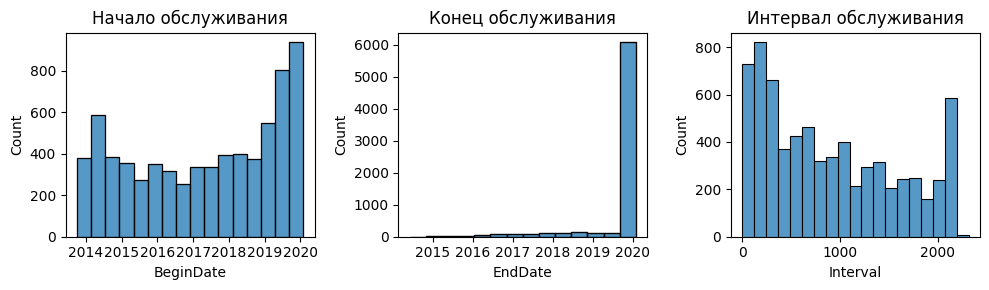

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 3))
sns.histplot(data=contract.BeginDate, ax=axs[0]).set_title('Начало обслуживания');
sns.histplot(data=contract.EndDate, ax=axs[1]).set_title('Конец обслуживания');
sns.histplot(data=contract.Interval, ax=axs[2]).set_title('Интервал обслуживания');
fig.tight_layout()

Самую важную информацию здесь нам дает столбец с целевым признаком, мы видим, что подавляющее число клиентов до сих пор остается с компанией, что для компании конечно хорошо, но в нашем случае дает дисбаланс таргетных классов. Столбец о начале обслуживания показывает небольшой скачок спроса в 2014г., потом относительно ровный приток клиентов и заметный прирост пользователей в течение 2019 года. А вот интервал показывает большее количество пользователей с меньшим стажем, но есть и доля пользователей с максимальным стажем, но в данном случае эти показатели нужно рассматривать во взаимосвязи с данными о том, когда прекратилось и прекратилось ли вообще обслуживание, что я сейчас и сделаю.

In [ ]:
contract[['EndDate', 'Interval']].value_counts().to_frame(name='Итого:')

Итого:
EndDate    Interval        
2020-02-01 2191         265
           92           237
           123          236
           153          236
           31           233
...                     ...
2018-02-01 215            1
           337            1
           488            1
           549            1
2018-08-01 761            1

[918 rows x 1 columns]

Здесь мы видим, что большая часть пользователей, имеющих максимальный стаж, продолжают оставаться с компанией. Сейчас посмотрим на интервал пользователей, которые все-таки прервали договор обслуживания.

In [ ]:
contract[contract.EndDate!='2020-02-01'].Interval.value_counts().to_frame(name='Итого:')

,Итого:
Interval,
1461,18
1035,14
822,13
153,13
1096,13
...,...
1311,1
2068,1
672,1


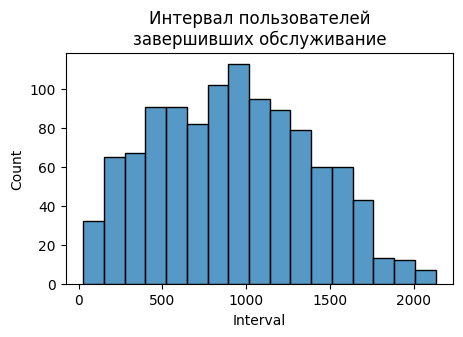

In [ ]:
plt.figure(figsize=(5, 3))
sns.histplot(data=contract[contract.EndDate!='2020-02-01'].Interval).set_title('Интервал пользователей\nзавершивших обслуживание');

Мы видим, что распределение этого признака выглядит нормальным,  большее количество пользователей, разорвавших договор, обслуживалось около 1000 дней.

In [ ]:
for x in contract.TotalCharges:
    try:
        contract.TotalCharges.astype('float')
    except:
        contract.TotalCharges.astype('object')

In [ ]:
contract.TotalCharges = contract.TotalCharges.replace(' ', 0)
contract.TotalCharges = contract.TotalCharges.astype(float)

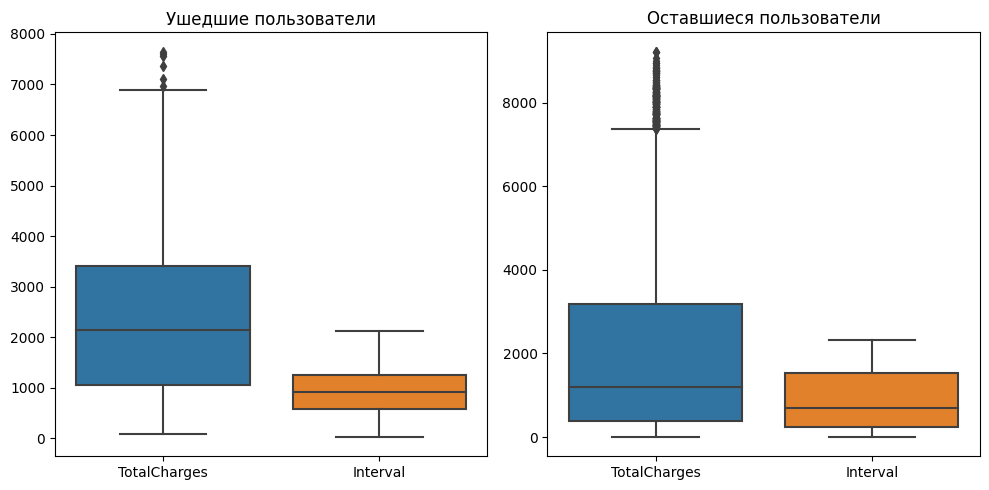

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.boxplot(data=contract[contract.EndDate!='2020-02-01'].drop('MonthlyCharges', axis=1),
            ax=axs[0]).set_title('Ушедшие пользователи')
sns.boxplot(data=contract[contract.EndDate=='2020-02-01'].drop('MonthlyCharges', axis=1),
            ax=axs[1]).set_title('Оставшиеся пользователи')
fig.tight_layout()

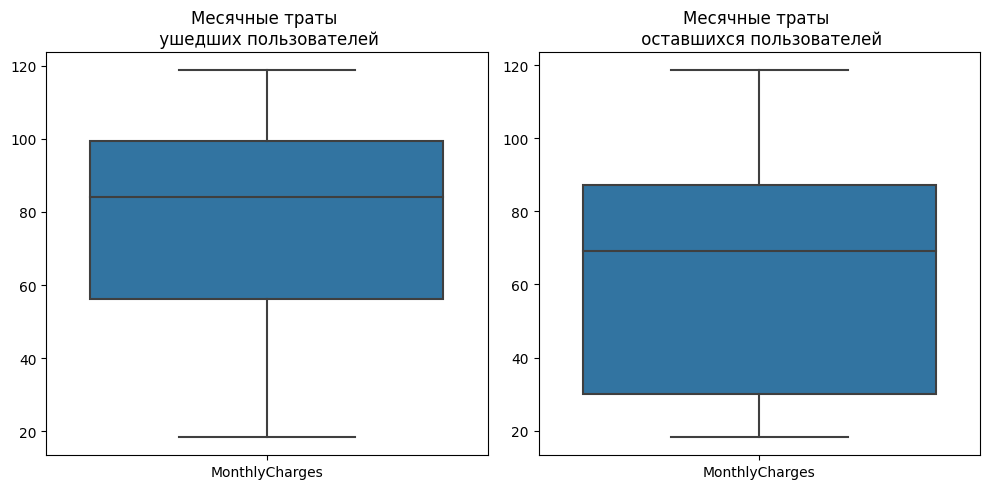

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.boxplot(data=contract[contract.EndDate!='2020-02-01'].drop(['TotalCharges', 'Interval'], axis=1),
            ax=axs[0]).set_title('Месячные траты \n ушедших пользователей')
sns.boxplot(data=contract[contract.EndDate=='2020-02-01'].drop(['TotalCharges', 'Interval'], axis=1),
            ax=axs[1]).set_title('Месячные траты \n оставшихся пользователей')
fig.tight_layout()

Общие и месячные траты распределяются у ушедших и оставшихся пользователей по-разному: медианные значения значительно ниже(в случае итоговых трат практически в два раза).

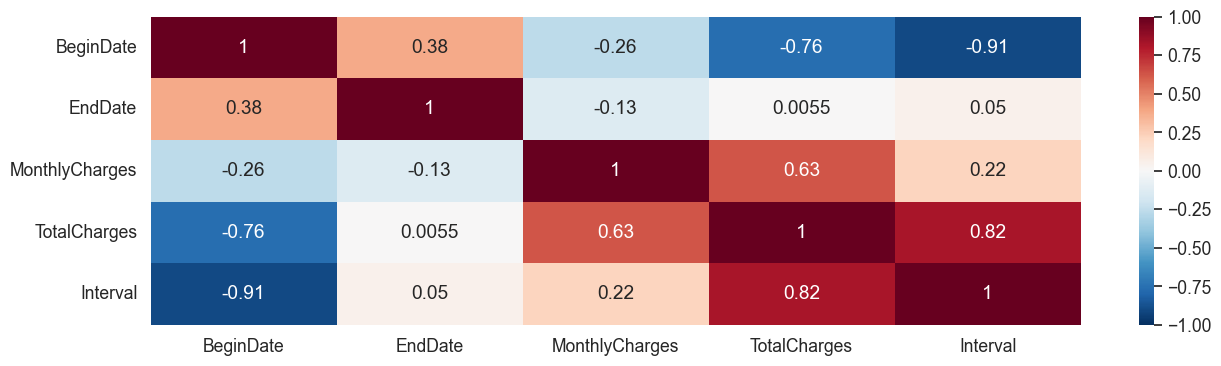

In [ ]:
sns.set(font_scale=1.15)
plt.figure(figsize=(15,4))
sns.heatmap(
    contract[['BeginDate', 'EndDate', 'MonthlyCharges',
    'TotalCharges', 'Interval']].corr(),        
    cmap='RdBu_r', 
    annot=True,
    vmin=-1, vmax=1);

***Выводы по корелляции признаков:***
- наибольшей положительной взаимосвязью обладают признаки Интервал и Итоговые траты, что вполне логично(чем больше пользуешься, тем больше заплатил), как и максимальная отрицательная связь между Началом договора и Интервалом и Началом договора и Итоговыми тратами. 
- есть положительная корелляция между Месячными тратами и Интервалом, это может быть обосновано как повышением цен так и возрастанием вовлеченности пользователя в услуги, на это мы посмотрим в общей таблице.

***Датасет Личные данные:***
- на основании имеющихся данных проанализируем портрет пользователя услуг компании.

In [ ]:
personal[['gender',	'SeniorCitizen', 'Partner',	'Dependents']].value_counts().to_frame(name='Итого:')

Итого:
gender SeniorCitizen Partner Dependents        
Male   0             No      No            1381
Female 0             No      No            1338
                     Yes     Yes            844
Male   0             Yes     Yes            822
Female 0             Yes     No             596
Male   0             Yes     No             567
Female 1             No      No             317
Male   1             Yes     No             281
                     No      No             244
       0             No      Yes            211
Female 1             Yes     No             209
       0             No      Yes            142
Male   1             Yes     Yes             44
Female 1             Yes     Yes             39
Male   1             No      Yes              5
Female 1             No      Yes              3

По визуализации становится понятным, что основными пользователями услуг являются молодые, холостые люди обоих гендеров без иждивенцев, значительно ниже доля клиентов пенсионного возраста, минимально услугами пользуюся пенсионеры обоих гендеров, с наличием иждивенцев.

In [ ]:
internet.sample()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
679,9778-OGKQZ,DSL,Yes,Yes,Yes,Yes,Yes,Yes


***Датасет Интернет:***
Более подробно проанализируем количество пользователей определенных услуг компании.

In [ ]:
internet[['InternetService', 'OnlineSecurity', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies']].value_counts().to_frame(name='Итого:')

Итого:
InternetService OnlineSecurity DeviceProtection TechSupport StreamingTV StreamingMovies        
Fiber optic     No             No               No          No          No                  511
DSL             No             No               No          No          No                  391
Fiber optic     No             Yes              No          Yes         Yes                 313
                               No               No          Yes         Yes                 284
DSL             Yes            Yes              Yes         Yes         Yes                 222
...                                                                                         ...
Fiber optic     Yes            Yes              No          No          Yes                  24
DSL             Yes            Yes              No          Yes         No                   22
Fiber optic     Yes            Yes              Yes         Yes         No                   18
                               No               Yes         Yes         No                   17
                                                            No          Yes                  17

[64 rows x 1 columns]

В предварительном анализе я уже писала, что больше всего клиентов с Интернет сервисом - Fiber optic, без подключения любых дополнительных опций. Также мы видим, что сервис Fiber optic	явно лидирует, а из дополнительных опций пользователи в основном пользуются StreamingTV	и StreamingMovies. Что интересно пользователи DSL гораздо чаще пользуются услугами Тех.поддержки)

Датасет Телефон отдельно я уже рассмотрела в предварительном анализе, и сдесь на нем останавливаться нет смысла. Теперь объединим наши датасеты в один общий. Там, где не будет хватать значений по столбцам из датасетов Интернет и Телефон, я проставлю No, так как это строковые столбцы и клиент данными услугами не пользуется.

In [ ]:
temp = contract.merge(personal, on='customerID')
temp_1 = temp.merge(internet, on='customerID', how='outer')
data = temp_1.merge(phone, on='customerID', how='outer')

In [ ]:
data = data.fillna('No')

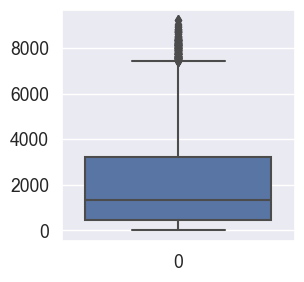

In [ ]:
plt.figure(figsize=(3, 3))
sns.boxplot(data=data.TotalCharges);

Мы получили датасет с большим объемом признаков, многие из которых не нужны. 
- Сначала я сгенерирую столбец с целевым признаком на основе столбца EndDate(1 - если клиент ушел, 0 - если остался, т.е. его дата -01.02.2020), затем удалю столбец EndDate и уберу некоторые признаки, которые не имеют влияния на целевой, либо просто сильно взаимосвязаны между собой, по сути дублируя друг друга. Это будут признаки:
- customerID(сам номер не несет никакой информации)
- BeginDate(очень сильно коррелирует с Interval)

In [ ]:
data['Target'] = np.where(data.EndDate!='2020-02-01', 1, 0)

In [ ]:
data = data.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

Теперь воспользуемся средствами библиотеки Рhik, посмотрим на коэффициенты взаимосвязей данных внутри нашего датасета.

In [ ]:
data.phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'Interval', 'SeniorCitizen', 'Target']


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Interval,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Target
Type,1.000000,0.106860,0.277462,0.388444,0.470860,0.634155,0.000000,0.086231,0.179736,0.147680,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.065498,0.094015
PaperlessBilling,0.106860,1.000000,0.370495,0.467812,0.201703,0.026799,0.000000,0.242133,0.013218,0.172593,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.252972,0.083398
PaymentMethod,0.277462,0.370495,1.000000,0.399526,0.335666,0.350964,0.000000,0.292725,0.243008,0.224903,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.339313,0.214832
MonthlyCharges,0.388444,0.467812,0.399526,1.000000,0.710905,0.387727,0.008175,0.304985,0.203545,0.184366,0.919002,0.551621,0.629541,0.667481,0.576525,0.835340,0.833307,0.675883,0.226280
TotalCharges,0.470860,0.201703,0.335666,0.710905,1.000000,0.848337,0.000000,0.135650,0.381958,0.084247,0.490081,0.522090,0.622445,0.640977,0.550065,0.641488,0.643210,0.573191,0.302890
Interval,0.634155,0.026799,0.350964,0.387727,0.848337,1.000000,0.000000,0.063315,0.453688,0.198729,0.060845,0.395693,0.414982,0.426931,0.404795,0.339313,0.339313,0.398222,0.374569
gender,0.000000,0.000000,0.000000,0.008175,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.018397,0.009882,0.000000,0.000000,0.000000,0.000000,0.000000,0.008581
SeniorCitizen,0.086231,0.242133,0.292725,0.304985,0.135650,0.063315,0.000000,1.000000,0.016992,0.324576,0.160702,0.057028,0.102065,0.090686,0.092565,0.163120,0.186141,0.221313,0.086159
Partner,0.179736,0.013218,0.243008,0.203545,0.381958,0.453688,0.000000,0.016992,1.000000,0.652122,0.000000,0.221673,0.219223,0.238079,0.185993,0.193258,0.182011,0.220101,0.226688
Dependents,0.147680,0.172593,0.224903,0.184366,0.084247,0.198729,0.000000,0.324576,0.652122,1.000000,0.108463,0.124945,0.031533,0.010416,0.096912,0.017331,0.058999,0.033103,0.046871


In [ ]:
matrix = data.phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'Interval', 'SeniorCitizen', 'Target']


In [ ]:
matrix[['MonthlyCharges', 'TotalCharges']]

,MonthlyCharges,TotalCharges
Type,0.388444,0.470860
PaperlessBilling,0.467812,0.201703
PaymentMethod,0.399526,0.335666
MonthlyCharges,1.000000,0.710905
TotalCharges,0.710905,1.000000
Interval,0.387727,0.848337
gender,0.008175,0.000000
SeniorCitizen,0.304985,0.135650
Partner,0.203545,0.381958
Dependents,0.184366,0.084247


- сразу бросается в глаза столбец с полом клиента, который не показывает никакой связи ни с одним из признаков, кроме как минимальной с двумя колонками, он будет удален.
- самая сильная корреляция показана между тратами за месяц и всеми признаками, относящимися ко всем интернет услугами, тут коэффициент взаимосвязи находится в диапазоне от 0.5 до 0.92, что указывает на мультиколинеарность, с другими признаками пакет интернет-услуг такой сильной связи не дает, поэтому я приняла решение также удалить столбец с месячными тратами.

In [ ]:
data = data.drop(['gender', 'MonthlyCharges'], axis=1)

In [ ]:
round(data.Target[data.Target==1].shape[0]/data.Target[data.Target==0].shape[0], 2)

0.19

***Выводы:***
- на данном этапе был выявлен целевой признак - это столбец с окончанием договора обслуживания, и на его основе сгенерирован стобец с целевым признаком - Target, по данным из этого столбца становится понятным, что мы столкнулись с проблемой дисбаланса классов - класс - 0 (когда клиенты продолжают обслуживаться) относится к классу 1(когда клиенты разорвали договор) в пропорции 4 к 1.
- также были изменены типы данных(приведены к timedate и float)
- добавлен новый признак Interval - стаж клиентского обслуживания
- проведен исследовательский анализ данных, выявлены закономерности в данных(относительно временных параметров пользования услугами, частоты пользования тех или иных дополнительных услуг), составлен портрет основного пользователя и характеристики пользователей, которые меньше пользуются услугами компании
- найдены и удалены выбросы в столбце с информацией по итоговым тратам на услуги компании
- все датасеты объединены в общую таблицу
- проанализированы коэффициенты взаимосвязи признаков датасета
- удалены признаки, не имеющие корреляции, либо обладающие мультиколинеарностью, датасет подготовлен к кодированию и машинному обучению

***<font color='province'>Подготовка данных к обучению модели машинного обучения:</font>***

- В данном подразделе я разделю выборку на обучающую и тестовую части
- Произведу кодирование переменных:
  - где обучу кодер на тренировочной части, а трансформирую уже отдельно тренировочную и тестовую части

In [ ]:
data_train, data_test = train_test_split(data, test_size=test_size, random_state=random_state)

In [ ]:
X_train = data_train.drop('Target', axis=1)
y_train = data_train.Target
X_test = data_test.drop('Target', axis=1)
y_test = data_test.Target

In [ ]:
ohe = OneHotEncoder(drop='first', handle_unknown='error')

In [ ]:
X_train_categ = X_train.drop(['TotalCharges', 'Interval'], axis=1)
X_test_categ = X_test.drop(['TotalCharges', 'Interval'], axis=1)

In [ ]:
X_train_num = X_train[['TotalCharges', 'Interval']]
X_test_num = X_test[['TotalCharges', 'Interval']]

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_num)

StandardScaler()

In [ ]:
col = scaler.get_feature_names_out(X_train_num.columns)

In [ ]:
X_train_scaled = pd.DataFrame(scaler.transform(X_train_num), columns=col,
    index=X_train_num.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_num), columns=col,
    index=X_test_num.index)

In [ ]:
ohe.fit(X_train_categ)

OneHotEncoder(drop='first')

In [ ]:
new_columns = ohe.get_feature_names_out(X_train_categ.columns)

In [ ]:
X_train_ohe = pd.DataFrame(ohe.transform(X_train_categ).toarray(), columns=new_columns,
    index=X_train_categ.index)
X_test_ohe = pd.DataFrame(ohe.transform(X_test_categ).toarray(), columns=new_columns,
    index=X_test_categ.index)

In [ ]:
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

Итак, данные разделены на тренировочную и тестовую части, категориальные признаки закодированы, можно переходить к выбору модели.

***<font color='province'>Выбор модели:</font>***
В этом подразделе посредством кросс_валидации и анализируя метрики AUC-ROC и Accuracy я буду выбирать лучшую модель для тестирования.

In [ ]:
index = []
scores = {"Accuracy": [], "ROC-AUC": []}
scoring = ["accuracy", "roc_auc"]

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent")

index += ["Dummy classifier"]
cv_result = cross_validate(dummy_clf, X_train, y_train, scoring=scoring)
scores["Accuracy"].append(cv_result['test_accuracy'].mean())
scores["ROC-AUC"].append(cv_result['test_roc_auc'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,ROC-AUC
Dummy classifier,0.84078,0.5


In [ ]:
lr_clf = LogisticRegression(max_iter=1000)
index += ["Logistic regression"]
cv_result = cross_validate(lr_clf, X_train, y_train, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["ROC-AUC"].append(cv_result['test_roc_auc'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,ROC-AUC
Dummy classifier,0.84078,0.500000
Logistic regression,0.86009,0.773072


In [ ]:
lr_clf.set_params(class_weight="balanced")
index += ["Logistic regression with balanced class weights"]
cv_result = cross_validate(lr_clf, X_train, y_train, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["ROC-AUC"].append(cv_result['test_roc_auc'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,ROC-AUC
Dummy classifier,0.840780,0.500000
Logistic regression,0.860090,0.773072
Logistic regression with balanced class weights,0.699355,0.772789


In [ ]:
rf_clf = RandomForestClassifier(random_state=random_state, n_jobs=2)
index += ["Random forest"]
cv_result = cross_validate(rf_clf, X_train, y_train, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["ROC-AUC"].append(cv_result['test_roc_auc'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,ROC-AUC
Dummy classifier,0.840780,0.500000
Logistic regression,0.860090,0.773072
Logistic regression with balanced class weights,0.699355,0.772789
Random forest,0.855356,0.811791


In [ ]:
rf_clf.set_params(class_weight="balanced")
index += ["Random forest with balanced class weights"]
cv_result = cross_validate(rf_clf, X_train, y_train, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["ROC-AUC"].append(cv_result['test_roc_auc'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,ROC-AUC
Dummy classifier,0.840780,0.500000
Logistic regression,0.860090,0.773072
Logistic regression with balanced class weights,0.699355,0.772789
Random forest,0.855356,0.811791
Random forest with balanced class weights,0.853841,0.810456


In [ ]:
lgbm_clf = LGBMClassifier(random_state=random_state, n_jobs=2)
index += ["LGBM"]
cv_result = cross_validate(lgbm_clf, X_train, y_train, scoring=scoring)
scores["Accuracy"].append(cv_result["test_accuracy"].mean())
scores["ROC-AUC"].append(cv_result['test_roc_auc'].mean())
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Accuracy,ROC-AUC
Dummy classifier,0.840780,0.500000
Logistic regression,0.860090,0.773072
Logistic regression with balanced class weights,0.699355,0.772789
Random forest,0.855356,0.811791
Random forest with balanced class weights,0.853841,0.810456
LGBM,0.886406,0.884160


Итак проверено четыре модели (наивная, логистическая регрессия, случайный лес и LGBM), две из них были представлены со сбалансированными весами и без них. Лушие результаты по обоим метрикам дала модель LGBM, ее я и буду тестировать.

***<font color='province'>Тестирование модели:</font>***
В этом подразделе я протестирую выбранную модель на тестовой выборке, используя GridSearchCV для подбора гиперпараметров. Затем опишу получившиеся метрики.

In [ ]:
score = make_scorer(roc_auc_score, greater_is_better=True)

In [ ]:
model = LGBMClassifier(random_state=random_state, n_jobs=2)
parametrs = {'boosting_type': ['gbdt', 'dart', 'rf'],
            'max_depth': range(5, 51, 5),
            'n_estimators': range (10, 401, 10)}
grid = GridSearchCV(model, parametrs, scoring=score)
grid.fit(X_train, y_train)

In [ ]:
grid.best_params_

{'boosting_type': 'gbdt', 'max_depth': 5, 'n_estimators': 390}

In [ ]:
probs = grid.best_estimator_.predict_proba(X_test)[:, 1]
preds = grid.best_estimator_.predict(X_test)
print('AUC-ROC: ', roc_auc_score(y_test, probs).round(2))
print('Accuracy: ', accuracy_score(y_test, preds).round(2))

AUC-ROC:  0.9
Accuracy:  0.92


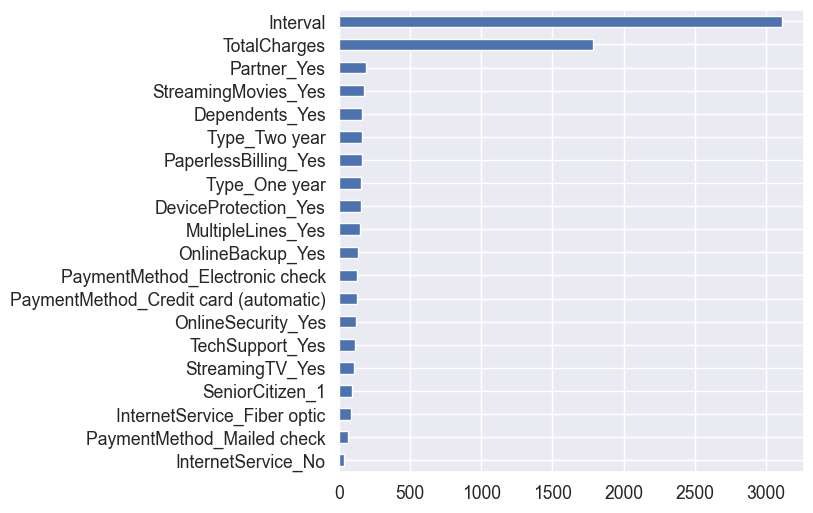

In [ ]:
pd.DataFrame(data={'score': grid.best_estimator_.feature_importances_}, 
                      index=X_train.columns).sort_values(by='score').plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False);

Для модели с большим отрывом от остальных по важности лидируют два признака: Interval и TotalCharges.

**Выводы:**
При помощи GridSearchCV были подобраны гиперпараметры 'boosting_type': 'gbdt', 'max_depth': 10, 'n_estimators': 390.
После проведения тестирования отобранной модели были получены метрики AUC-ROC и Accuracy равные 0.91, что удовлетворяет поставленной задаче.

<font color='province'>***Отчет по работе:***</font>

  Целью данного проекта было изучение возможности предсказания оттока клиентов телекоммуникационной компании по средством использования моделей машинного обучения.
  Random_state был зафиксирован как 50623, test_size - 0.25.
  В ходе выполнения данного задания были выполнены все пункты, ранее описаные в плане работ(отличий нет).

  Этапы работы:
  - <font color='purple'>предварительный осмотр имеющихся данных:</font>
    - были открыты и осмотрены четыре предоставленных датасета, данные проверены на остутствие пропусков и дубликатов. Проведен первичный анализ пока необработатнных данных(я посмотрела не распределение имеющихся численных признаков, сделала некоторые предварительные выводы о закономерностях в данных(группировка всех датасетов по идентификационному номеру пользователя, набросок портрета основного пользователя услуг компании, набросок проиритетов пользователей в пользовании интернет услуг, предлагаемых компанией), обратила внимание на столбец с окончанием срока действия договора, в котором в большинстве строк этот срок отсутствует).
  - <font color='purple'>предобработка и исследовательский анализ данных:</font>
    мною сначала были изучены данные, в необходимых случаях изменены типы данных каждого отдельного датасета, затем все датасеты были объединены в один общий датасет(по имеющимуся общему признаку - идентификационному номеру клиента) и уже в нем был проведен анализ взаимосвязей между всеми признаками и были отобраны признаки для обучения модели МО:
      - датасет Contract:
        - Был выявлен целевой признак, содержащийся в графе EndDate(окончание срока действия договора обслуживания),  т.е. клиенты, имеющие дату в этой колонке, являются отказавшимися от услуг компании и также являются основным предметом данного исследования. В свою очередь клиенты, не имеющие даты в этом столбце, продолжают пользоваться услугами компании и, значение 'No' в их данных было изменено на дату выгрузки датасета 01.02.2020.
        - Тип данных столбцов с началом и концом срока обслуживания был приведен к timedate.
        - На основе этих двух колонок был создан новый признак - Interval(timedelta) - это интервал времени пользования услугами компании для каждого клиента и приведен к численному типу.
        - Были визуализированы все три признака, характеризующие временные данные, был выявлен явный дисбаланс целевого признака(большинство(отношение 4 к 1) клиентов продолжают пользоваться услугами компании).
        - Были найдены пустые строки в строковой колонке с итоговыми тратами клиента(TotalCharges), они были заполнены нулями и тип данных приведен к численному.
        - Было выявлено, что итоговые и месячные траты распределяются у ушедших и оставшихся пользователей по-разному: медианные значения у оставшихся пользователей значительно ниже(в случае итоговых трат практически в два раза), возможно это повлияло на уход целевой группы.
      - датасет Personal:
        - был составлен портрет типичного пользователя услуг компании(молодые, холостые люди обоих гендеров без иждивенцев). Меньше всего пользуются услугами - пенсионеры обоих гендеров, с наличием иждивенцев.
      - датасет Internet:
        - были выявлены предпочтения клиентов в пользовании интернет услуг, предоставляемых компанией - большинство пользуется интернет сервисом - Fiber optic, без подключения любых дополнительных опций. Было также замечено, что сервис Fiber optic	явно лидирует, а из дополнительных опций пользователи в основном пользуются StreamingTV	и StreamingMovies. Что интересно пользователи DSL гораздо чаще пользуются услугами Тех.поддержки.
    - Было произведено объединение все датасетов в итоговый(так как не все клиенты пользуются интернетом или телефоном, пропуски в их строковых данных были заполнены как 'No').
    - Сгенерирован  бинарный столбец с целевым признаком Target на основе столбца EndDate(где 1 - если клиент ушел и его дата окончания договора не равна дате выгрузки датасета и 0 - в другом случае).
    - Удалены признаки не несущие информации(Id) и обладающие мультиколинеарностью с целевым (BeginDate, EndDate).
    - При помощи библиотеки phik были изучены коэффициенты взаимосвязей признаков внутри итогового датасета, после этого удален столбец Gender(практически не имеющий корреляции ни с одним из признаков) и столбец MonthlyCharges(обладающий мультиколинеарностью со всеми признаками, относящимися к интернет услугам).
  - <font color='purple'>Подготовка данных к обучению модели МО:</font>
    - Выборка данных была разделена на обучающую и тестовую части.
    - Категориальные признаки были закодированы при помощи OHE, а количественные масштабированы при помощи StandartScaler(обучение производилось на только обучающей выборке, трансформация на обеих).
  - <font color='purple'>Выбор модели МО:</font>
    - Признаки, участвующие в обучении и отборе моделей: 'Type_One year', 'Type_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'SeniorCitizen_1', 'Partner_Yes', 'Dependents_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
       'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes',
       'MultipleLines_Yes', 'TotalCharges', 'Interval'
        и целевой признак - 'Target'
    - посредством кросс_валидации и анализируя метрики AUC-ROC и Accuracy была отобраны лучшая модель для тестирования.
    - в процессе проверялись такие модели как: наивная, логистическая регрессия, случайный лес и LGBM, две из них (логистическая регрессия и случайный лес)были представлены со сбалансированными весами и без них.
    - лучшие показатели метрик(а именно AUC-ROC - 0.88, Accuracy - 0.88) показала модель LGBM, которая и была отобрана для финального тестирования.
  - <font color='purple'>Тестирование модели:</font>
    - Используя GridSearchCV были перебраны гиперпараметры, scoring при помощи функции make-scorer был установлен на максимизацию искомой метрики AUC-ROC.
    - Лучшими гиперпараметрами для данной модели стали: 'boosting_type': 'gbdt', 'max_depth': 5, 'n_estimators': 390.
    - После проведения тестирования отобранная модель показала следующие результаты:
      - AUC-ROC - 0.9
      - Accuracy - 0.92
    - Была визуализирована важность признаков для работы данной модели МО: важнейшими признаками(причем со значительным отрывом от остальных) стали Interval и TotalCharges(то есть большим влиянием на отток клиентов обладают продолжительность пользования услугами компании(или клиентская лояльность) и сумма итоговых трат клиента(что подтверждает выводы, сделанные в исследовательском анализе.))